# Mid section coefficient $\sigma$ statistics

# Purpose
We have found that the section coefficients cannot exceed 0.99 in ikedas eddy damping prediction. This notebook investigates how commonly the mid section area coefficient exceeds 0.99.

# Methodology
Load mid section coefficients from the MDL DB

# Setup

In [2]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [3]:
sql = """
select * from loading_conditions
	inner join models on loading_conditions.model_number=models.model_number
		inner join ships on models.ship_name=ships.name
        	inner join association on association.ship_name=ships.name
            	inner join projects on projects.project_number=association.project_number
        
"""

In [8]:
db = database.get_db()
loading_conditions = pd.read_sql(sql=sql, con=db.engine, index_col='id')

In [9]:
loading_conditions.head()

,name,model_number,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,model_number,ship_name,scale_factor,name,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA,ship_type_id,project_number,ship_name,project_number,name,project_path
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,8.57,M3522-A,-1.63,10.16,1.25,0.833,8.57,8.57,25.9,9.01,41.04,2.547,0.7253,26622.0,0.9862,5.8,M3522-A,M3522-A,55.00,M3522-A,167.68,25.9,35.0,0.0,1.0,5.74,20.70,6.05,144.0,1.2000,0.0,None,None,13500.0,3.0,NaN,58.70,1.05,3.0,5.4,46.0,2.32,-57.0,103.0,18.4,0.0,0.0,2.0,1.0,-83.84,None,6.2,4.5,181.45,8.0,30126505,M3522-A,30126505,30126505 BMT Naval Supply vessel,S:\2012\30126505 BMT Naval Supply vessel
2,6.94,M3522-A,-0.04,9.67,2.09,0.786,6.94,6.94,25.9,10.09,44.22,1.968,0.7005,20752.0,0.9830,5.8,M3522-A,M3522-A,55.00,M3522-A,167.68,25.9,35.0,0.0,1.0,5.74,20.70,6.05,144.0,1.2000,0.0,None,None,13500.0,3.0,NaN,58.70,1.05,3.0,5.4,46.0,2.32,-57.0,103.0,18.4,0.0,0.0,2.0,1.0,-83.84,None,6.2,4.5,181.45,8.0,30126505,M3522-A,30126505,30126505 BMT Naval Supply vessel,S:\2012\30126505 BMT Naval Supply vessel
3,12.0,3161-A,-2.45,18.84,4.82,0.858,12.00,12.00,50.0,16.50,71.30,3.180,0.7714,139566.0,0.9960,10.2,3161-A,3161-A,53.74,3161-A,302.00,50.0,49.5,-4.1,1.0,9.80,20.35,10.45,218.0,0.9918,12.8,None,None,28034.0,1.0,NaN,80.94,0.40,3.0,7.9,49.0,2.32,-125.0,79.5,68.6,0.0,0.0,2.0,1.0,-151.00,None,9.3,36.0,314.00,4.0,20053838,3161-A,20053838,20053838,\\sspa.local\gbg\ProjektArkiv\2005\20053838
4,9.6,3161-A,-1.02,14.93,11.09,0.828,9.60,9.60,50.0,20.00,77.70,2.800,0.7532,108940.0,0.9950,10.2,3161-A,3161-A,53.74,3161-A,302.00,50.0,49.5,-4.1,1.0,9.80,20.35,10.45,218.0,0.9918,12.8,None,None,28034.0,1.0,NaN,80.94,0.40,3.0,7.9,49.0,2.32,-125.0,79.5,68.6,0.0,0.0,2.0,1.0,-151.00,None,9.3,36.0,314.00,4.0,20053838,3161-A,20053838,20053838,\\sspa.local\gbg\ProjektArkiv\2005\20053838
5,7.0,3166,-3.85,10.00,11.10,NaN,7.00,7.00,NaN,NaN,NaN,NaN,NaN,12412.0,NaN,NaN,3166,3166,27.93,3166,94.30,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,20054025,3166,20054025,20054025 RAMFORM100,\\sspa.local\gbg\ProjektArkiv\2005\20054025 RA...


In [15]:
loading_conditions.describe()

,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,HSKEG,RSKEG,LOA,ship_type_id,project_number,project_number
count,166.000000,166.000000,166.000000,99.000000,166.000000,166.000000,104.000000,105.000000,105.000000,76.000000,99.000000,166.000000,103.000000,97.000000,154.000000,158.000000,166.000000,83.000000,106.000000,110.000000,83.000000,96.000000,83.000000,83.000000,98.000000,81.000000,87.000000,107.000000,2.0,113.000000,108.000000,81.000000,105.000000,83.000000,83.000000,83.000000,83.000000,110.000000,83.0,83.0,108.000000,106.000000,83.000000,83.000000,83.000000,110.000000,70.000000,1.660000e+02,1.660000e+02
mean,3.287681,11.234771,6.441651,0.853576,9.139735,9.383952,42.642212,15.486857,59.486476,2.344487,1.516948,82391.674699,0.981872,9.598660,48.280990,218.084633,37.184078,38.703614,3.491368,0.427273,4.407590,17.728646,10.476145,132.187952,0.856557,11.250741,16964.885057,1.532710,49.5,66.332655,0.357398,2.012346,7.350667,28.448193,2.518867,-112.077108,90.789157,60.755273,0.0,0.0,1.518519,1.066038,-129.569759,7.921205,15.925904,253.604818,4.157143,2.313056e+07,2.313056e+07
std,16.494796,5.951431,10.133628,0.057927,5.463688,5.428838,12.361371,4.521961,16.517887,0.918263,7.460971,84059.329612,0.048530,3.348669,13.737312,89.336724,16.537831,27.484867,11.239162,0.496946,4.449252,2.717388,3.109978,55.694542,0.128879,9.831539,7489.787480,1.290881,0.0,30.997376,0.171081,1.006154,1.728519,7.249178,0.905185,25.442423,34.791469,38.307828,0.0,0.0,0.587748,0.483418,29.589814,1.558740,13.412493,69.839454,2.470907,1.023319e+07,1.023319e+07
min,-12.570000,0.000000,0.000000,0.560000,0.000000,0.000000,9.690000,4.360000,10.900000,0.340000,0.475100,0.000000,0.618000,0.000000,10.000000,0.000000,0.000000,0.000000,-29.300000,0.000000,0.000000,10.000000,0.000000,22.000000,0.671000,0.000000,1900.000000,0.000000,49.5,0.000000,0.000000,1.000000,2.200000,13.500000,2.320000,-151.000000,65.100000,0.000000,0.0,0.0,0.000000,1.000000,-174.000000,2.900000,0.000000,50.200000,1.000000,2.005384e+07,2.005384e+07
25%,-1.611000,8.191250,1.400000,0.833000,5.995000,6.314500,37.250000,13.980000,52.300000,1.937500,0.746150,10399.000000,0.987250,7.700000,43.575000,169.260000,30.550000,19.000000,-0.090000,0.000000,0.000000,15.600000,9.200000,108.000000,0.720000,0.000000,10348.000000,1.000000,49.5,54.570000,0.300000,1.000000,6.600000,24.000000,2.320000,-125.000000,73.000000,37.820000,0.0,0.0,1.000000,1.000000,-144.000000,6.800000,7.450000,221.250000,3.250000,2.009537e+07,2.009537e+07
50%,0.000000,12.140000,3.755000,0.851000,9.400000,9.400000,45.600000,15.500000,64.100000,2.349500,0.770000,70747.500000,0.993000,9.600000,50.340000,242.000000,43.200000,43.100000,0.150000,0.000000,5.400000,17.600000,10.000000,130.000000,0.870000,10.300000,18820.000000,1.000000,49.5,78.660000,0.400000,3.000000,7.600000,28.000000,2.320000,-122.000000,79.000000,51.200000,0.0,0.0,2.000000,1.000000,-139.500000,7.800000,11.100000,288.250000,4.000000,2.012643e+07,2.012643e+07
75%,4.765000,16.382500,7.581250,0.898000,11.900000,11.900000,47.000000,18.200000,70.500000,2.835000,0.809400,117188.250000,0.996000,10.800000,55.000000,280.400000,46.950000,49.000000,9.412500,1.000000,8.900000,20.000000,11.250000,150.000000,0.928000,15.900000,22680.000000,1.000000,49.5,88.000000,0.430000,3.000000,8.300000,31.500000,2.320000,-99.000000,97.100000,74.275000,0.0,0.0,2.000000,1.000000,-112.600000,8.580000,22.000000,295.000000,4.000000,2.015766e+07,2.015766e+07
max,140.030000,22.620000,77.420000,0.950000,23.000000,23.000000,70.000000,24.050000,87.000000,4.920000,75.000000,425350.000000,0.999000,16.000000,72.860000,348.000000,70.000000,113.000000,36.000000,1.000000,10.250000,25.000000,16.400000,290.000000,1.200000,46.800000,28034.000000,6.000000,49.5,117.600000,1.050000,3.000000,10.200000,49.000000,10.000000,-26.500000,286.800000,158.330000,0.0,0.0,3.000000,5.000000,0.000

array([[<AxesSubplot:title={'center':'A0'}>]], dtype=object)

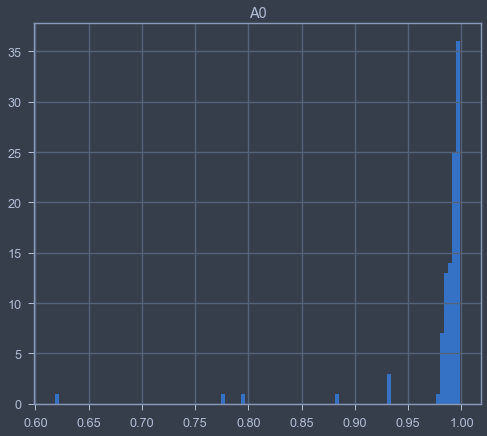

In [18]:
loading_conditions.hist('A0', bins=100)

<a id='sigma'></a>

Text(0.5, 1.0, 'Mid section coefficient')

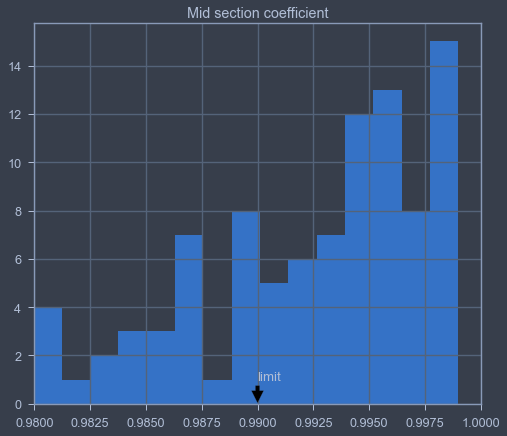

In [28]:
fig,ax=plt.subplots()
loading_conditions.hist('A0', bins=300, ax=ax)
ax.set_xlim((0.98,1))
ax.annotate('limit', xy=(0.99,0), xytext=(0.99,1), arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_title('Mid section coefficient')